In [1]:
%%html
<style>
body {
    font-family: "Consolas", Times;
}
</style>

# Prostate Cancer Patient Outcome Prediction using Clinical and Genomic Features

#### Flemming Wu

## Steps:
* [Exploratory Data Analysis](#first-bullet)
* [Handling Missing Values](#second-bullet)
* [Handling Class Imbalance](#third-bullet)
* [Encoding Categorical Variables](#fourth-bullet)
* [Feature Selection](#fifth-bullet)
* [Model Building](#sixth-bullet)
* [Hyperparamter Tuning](#seventh-bullet)

### Import packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import f_classif, SelectKBest, RFE
from imblearn.over_sampling import SMOTENC
from boruta import BorutaPy
from xgboost import XGBClassifier

### Read in data from cBioPortal

[https://www.cbioportal.org/study/summary?id=prad_msk_stopsack_2021](https://www.cbioportal.org/study/summary?id=prad_msk_stopsack_2021)

In [3]:
clinical_df = pd.read_csv('./prad_msk_stopsack_2021_clinical_data.tsv', sep='\t')
clinical_df.columns = clinical_df.columns.str.replace(' ', '_').str.replace('\'', '').str.lower()
genomic_df = pd.read_csv('./data_cna.txt', sep='\t').set_index('Hugo_Symbol').T.reset_index()

df = pd.merge(clinical_df, genomic_df, how='left', left_on='sample_id', right_on='index').drop(columns=['index'])

## Exploratory Data Analysis <a class="anchor" id="first-bullet"></a>

In [4]:
df.head()

,study_id,patient_id,sample_id,8q_arm,age_at_diagnosis,age_at_procurement,cancer_type,cancer_type_detailed,disease_extent_at_time_impact_was_sent,fraction_genome_altered,...,PTPRS,PTPRD,BRAF,FAM175A,SDHA,PDPK1,BAP1,SDHB,SDHD,PRKAR1A
0,prad_msk_stopsack_2021,P-0000140,P-0000140-T01-IM3,Gain,42.6,44.0,Prostate Cancer,Prostate Neuroendocrine Carcinoma,Metastatic castration-resistant,0.5462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,prad_msk_stopsack_2021,P-0000197,P-0000197-T01-IM3,Neutral,79.6,80.4,Prostate Cancer,Prostate Adenocarcinoma,Metastatic castration-resistant,0.0604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,prad_msk_stopsack_2021,P-0000373,P-0000373-T01-IM3,Neutral,54.9,55.2,Prostate Cancer,Prostate Adenocarcinoma,Metastatic hormone-sensitive,0.0023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,prad_msk_stopsack_2021,P-0000377,P-0000377-T01-IM3,Gain,60.0,61.3,Prostate Cancer,Prostate Adenocarcinoma,Metastatic castration-resistant,0.5102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,prad_msk_stopsack_2021,P-0000391,P-0000391-T01-IM3,Neutral,45.5,45.8,Prostate Cancer,Prostate Adenocarcinoma,Regional nodes,0.0134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.describe()

,age_at_diagnosis,age_at_procurement,fraction_genome_altered,mutation_count,prostate-specific_antigen,number_of_samples_per_patient,tmb_(nonsynonymous),TAP1,ERRFI1,STK19,...,PTPRS,PTPRD,BRAF,FAM175A,SDHA,PDPK1,BAP1,SDHB,SDHD,PRKAR1A
count,2069.000000,2069.000000,2069.000000,1831.000000,1953.000000,2069.0,2069.000000,2069.000000,2069.000000,2069.000000,...,2069.000000,2069.000000,2069.000000,2069.00000,2069.000000,2069.0,2069.00000,2069.000000,2069.000000,2069.000000
mean,62.498840,65.391107,0.152194,4.908793,95.263082,1.0,3.900291,-0.000967,0.001933,-0.001692,...,-0.000967,-0.010875,0.002900,-0.00290,0.006767,0.0,0.00000,-0.001933,-0.002900,0.000967
std,8.659238,9.195747,0.155982,16.454471,500.130536,0.0,13.544842,0.043969,0.087939,0.054949,...,0.076169,0.143366,0.098299,0.07612,0.116163,0.0,0.08796,0.062167,0.098299,0.098337
min,35.600000,36.700000,0.000000,1.000000,0.000000,1.0,0.000000,-2.000000,-2.000000,-2.000000,...,-2.000000,-2.000000,-2.000000,-2.00000,0.000000,0.0,-2.00000,-2.000000,-2.000000,-2.000000
25%,56.300000,59.000000,0.025200,2.000000,5.300000,1.0,0.978720,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000
50%,62.800000,65.500000,0.106000,3.000000,9.200000,1.0,2.218311,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000
75%,68.300000,71.600000,0.229900,4.000000,26.800000,1.0,3.458792,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000
max,94.000000,94.000000,0.796500,539.000000,11330.000000,1.0,466.936971,0.000000,2.000000,0.000000,...,2.000000,0.000000,2.000000,0.00000,2.000000,0.0,2.00000,0.000000,2.000000,2.000000


In [6]:
df.number_of_samples_per_patient.to_frame().query('number_of_samples_per_patient > 1')

,number_of_samples_per_patient


Each patient is associated with only one sample

In [7]:
df.sample_class.unique()

array(['Tumor'], dtype=object)

In [8]:
df.cancer_type.unique()

array(['Prostate Cancer'], dtype=object)

In [9]:
df.shape

(2069, 566)

##### Information about the columns:

- 8q_arm: The chromosome 8q arm contains several genes involved in prostate cancer development and progression. It is the most amplified chromosomal segment in advanced metastatic castration-resistant prostate cancer after chXq12.

- age_at_procurement: age at time samples sent for sequencing

- disease_extent_at_time_impact_was_sent: 
    
    - Localized (not metastasized)
    
    - Metastatic hormone-sensitive (precursor to Metastatic castration-resistant) - advanced forms of the condition that don’t respond to initial treatments, such as surgery and hormone therapy, and have started to spread beyond the prostate

    - Non-metastatic castration-resistant

    - Metastatic castration-resistant does not respond to standard hormone treatment called androgen deprivation therapy

    - Regional nodes

    - Metastatic, variant histology

- gleason_grade: 

    - < 6 - grade group 1, low grade, low risk 

    - 7 (3 + 4) - grade group 2, intermediate risk 
    
    - 7 (4 + 3) - grade group 3, intermediate risk

    - 8 - grade group 4, high risk

    - 9-10 - grade group 5, very high risk

- m_stage: M0 means no distant spread found, M1 means cancer has spreaad

- prostate-specific_antigen: protein produced by prostate gland, normal to have low levels in blood, high PSA can be caused by cancer. Units are in ng/ml 

- sample_class: the sample classification (i.e., tumor, cellline, xenograph)

- sample_type: the type of sample (i.e., normal, primary, met, recurrence)

- tmb_(nonsynonymous): the total number of nonsynonymous mutations per coding area of a tumor genome

- tumor_sample_histology: histopathologists annotation, values are mostly (Adenocarcinoma/poorly differentiated carcinoma)

##### Preliminary drop unnecessary columns

Identification columns such as study id, patient id, and sample id are not needed (will set sample id as index). 

All cancer types are prostate, as this is a prostate cancer dataset, all patients have 1 sample, the sample class is all "tumor", so this information will not be useful.

Additionally, the gene panel information is likely to not be useful.

In [10]:
df = df.set_index(df['sample_id'])
df = df.drop(columns=['study_id', 'patient_id', 'sample_id', 'cancer_type', 'gene_panel', 'number_of_samples_per_patient', 'sample_class']) 

## Handling Missing Values <a class="anchor" id="second-bullet"></a>

In [11]:
df.isnull().sum().to_frame('num_missing').sort_values('num_missing', ascending=False).query('num_missing > 1')

,num_missing
mutation_count,238
gleason_grade,168
prostate-specific_antigen,116
smoking,55
tumor_sample_histology,18
sample_type,17


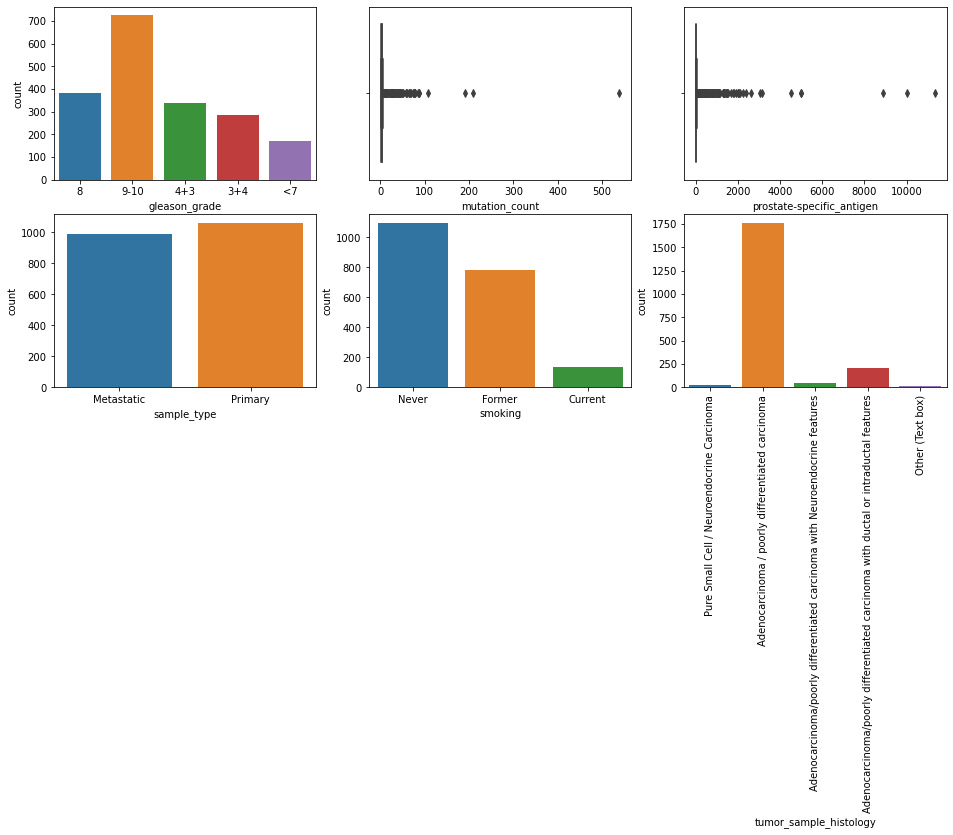

In [12]:
missing = ['gleason_grade', 'mutation_count', 'prostate-specific_antigen', 'sample_type', 'smoking', 'tumor_sample_histology']

fig, axs = plt.subplots(2,3, figsize=(16,7))
for col, ax in zip(df[missing].columns, axs.flat):
    if df[col].dtype == object:
        sns.countplot(data=df, x=col, ax=ax)
        if col == 'tumor_sample_histology':
            ax.tick_params(axis='x', rotation=90)
    else:
        sns.boxplot(data=df, x=col, ax=ax)

In [13]:
df['mutation_count'].corr(df['tmb_(nonsynonymous)'])

0.9992752138120058

Tumor mutational burden and mutation count are highly correlated, as expected. Since they represent the same information, I will drop the mutation count column and keep tumor mutational burden.

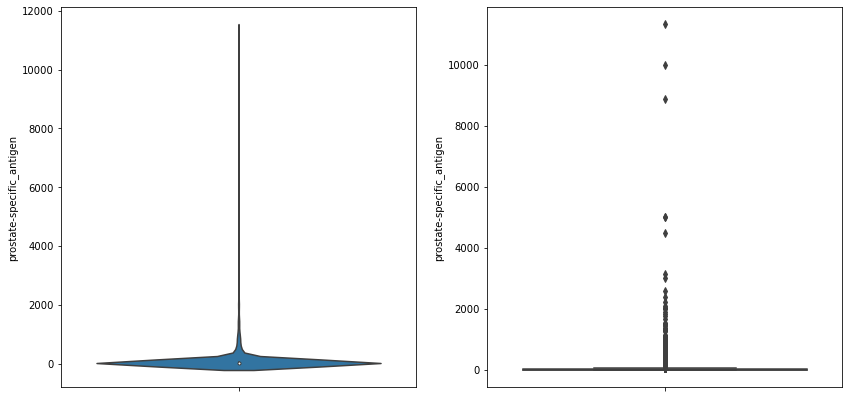

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14,7))
sns.violinplot(data=df, y='prostate-specific_antigen', ax=axes[0])
sns.boxplot(data=df, y='prostate-specific_antigen', ax=axes[1]);

According to the NIH National Cancer Institute, PSA levels of 4.0 ng/mL and lower are considered normal. Here, there can be some outliers seen with some patients having recorded a PSA level of over 8000 ng/mL. There are quite a few even over 2000. I will remove observations with PSA > 2000.

How I will handle the missing values:

- mutation_count: I will remove column and keep the tumor mutational burden column as it represents the same information and does not have any missing values.

- gleason_grade: First I will ordinally encode this column, then impute with median or mean

- prostate-specific_antigen: This has a very skewed distribution, so I will encode with the mdedian. I will also have to take care of some outliers.

- tumor_sample_histology: This column has a clear mode, so I will replace the missing values with the mode

- smoking, and sample_type: Only a small percentage of these features are missing these values and there is no clear mode, so I will just remove rows with missing values.

In [15]:
# convert gleason grade values to ordinal
df['gleason_grade'] = df['gleason_grade'].map({
    '<7' : 1,
    '3+4' : 2,
    '4+3' : 3,
    '8' : 4,
    '9-10' : 5
})
# fill gleason grade with median
df['gleason_grade'] = df['gleason_grade'].fillna(df['gleason_grade'].median())


# drop mutation count column
df = df.drop(columns=['mutation_count'])


# remove outlier PSA observations
df = df.loc[df['prostate-specific_antigen'] < 2000]
# fill rest of na with median
df['prostate-specific_antigen'] = df['prostate-specific_antigen'].fillna(df['prostate-specific_antigen'].median())


# fill tumor sample histology with mode
df['tumor_sample_histology'] = df['tumor_sample_histology'].fillna(df['tumor_sample_histology'].mode()[0])


# remove observations with missing values in rest of columns
df = df.dropna(subset=['smoking', 'sample_type'])

In [16]:
df.isna().sum().sum()

0

In [17]:
df.shape

(1873, 558)

1873 observations remain

## Handling Class Imbalance <a class="anchor" id="third-bullet"></a>

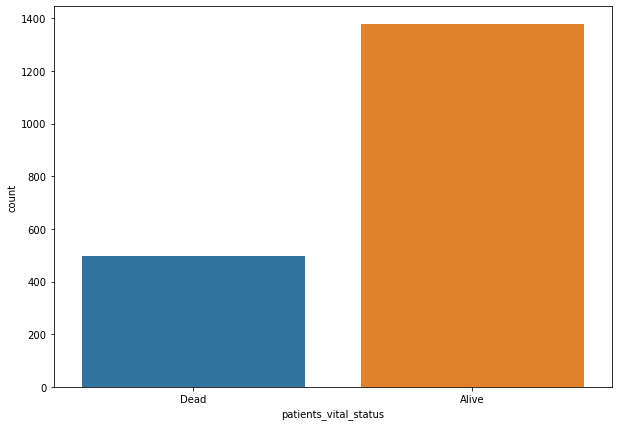

In [18]:
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.countplot(data=df, x='patients_vital_status');

The minority class makes up a little less than 30% of target variables, so there is some mild class imbalance. If the model always predicts 1, it can achieve 73% accuracy.


I will choose to implement SMOTE for handling class imbalance as opposed to random undersampling or random oversampling. Random undersampling the majority class can lead to loss of information, and is not a great choice when I have less than 2000 observations. Random oversampling may introduce some bias and noise into the training data, as duplicating samples may result in a biased representation of the original data distribution.

Instead, I will implement SMOTE to handle class imbalance, which introduces artificial data points drawn from the nearest neighbors of the existing samples in the feature space. It is an oversampling technique, so this will be done for the minority class. Furthermore, I will be using the SMOTENC variation, which can handle categorical features along with numerical features.

In [19]:
categorical_columns = [True if col in df.select_dtypes(object).columns and col != 'patients_vital_status' else False for col in df.columns]

sm = SMOTENC(categorical_features=categorical_columns, sampling_strategy='minority', random_state=10)
X_res, y_res = sm.fit_resample(df.loc[:, df.columns != 'patients_vital_status'].reset_index(drop=True), df['patients_vital_status'])

In [20]:
# keep data before oversampling
df_before_sampling = df.copy()

# reassign df to new sampled data set
df = X_res
df['target'] = y_res

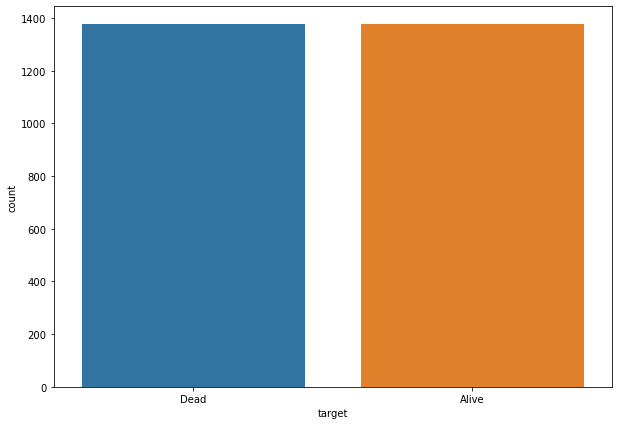

In [21]:
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.countplot(data=df, x='target');

## Encoding Categorical Variables <a class="anchor" id="fourth-bullet"></a>

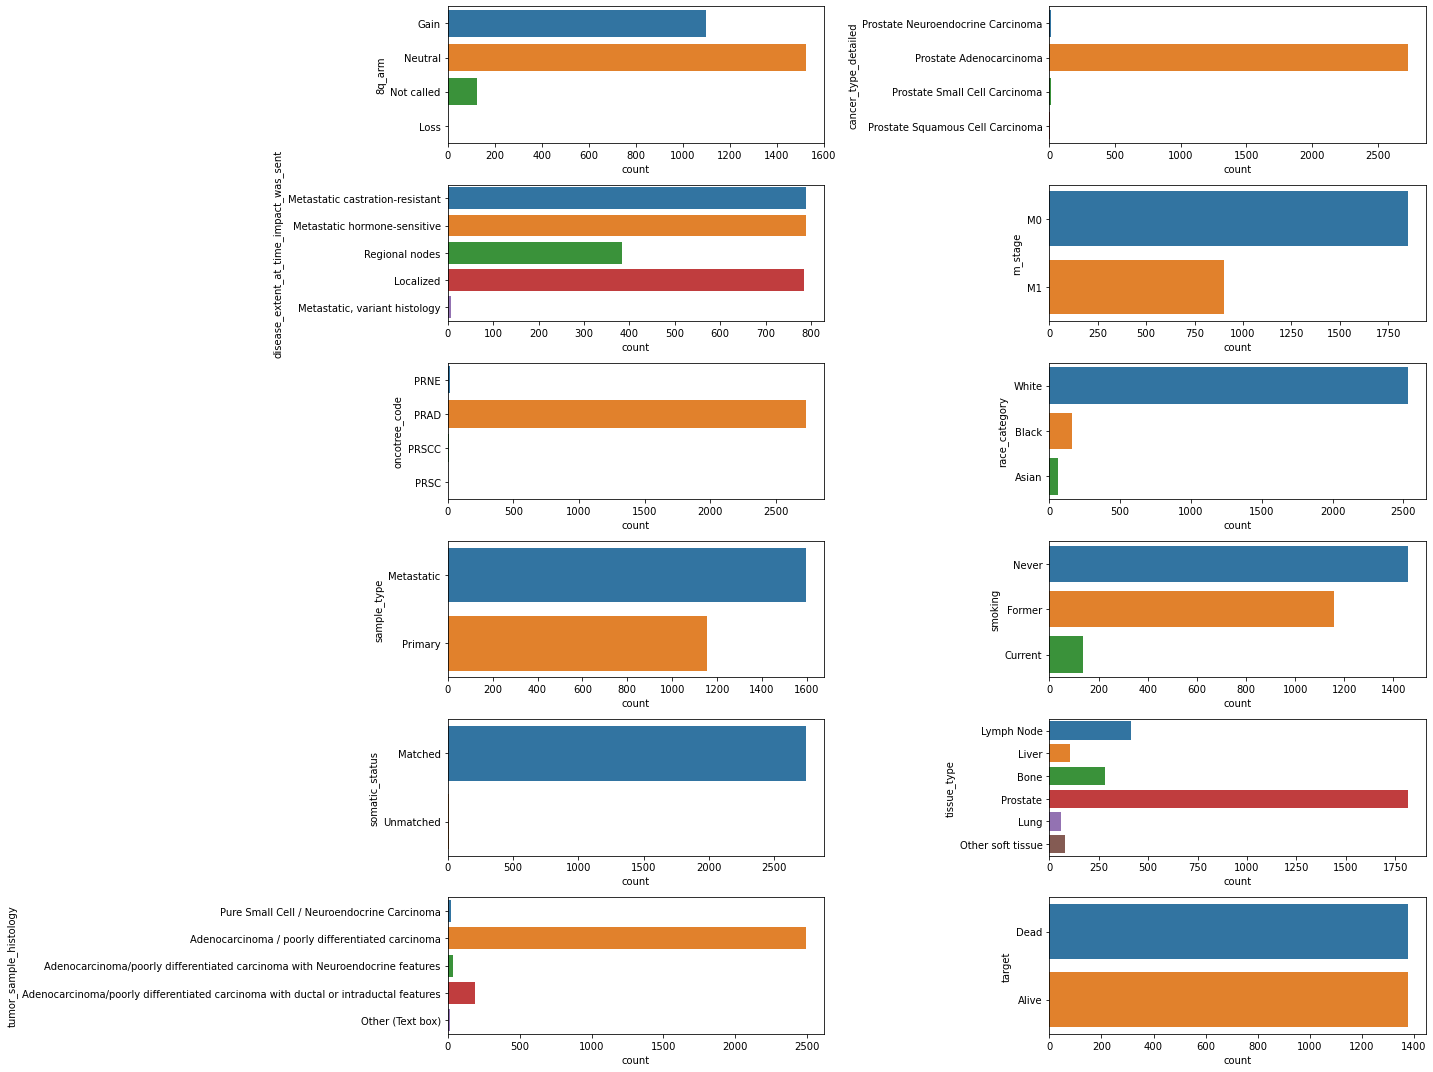

In [22]:
## plot value counts of categorical columns
fig, axs = plt.subplots(6, 2, figsize=(20,15), tight_layout=True)
for col, ax in zip(df.select_dtypes(object), axs.flat):
    sns.countplot(data=df, y=col, ax=ax)

How I will encode the categorical variables:

A few of the columns are very imbalanced, such as oncotree_code, somatic_status, and cancer_type_detailed, with the majority of observations falling into one category. For these features, there may not be enough training examples from minority classees for the model to learn from, and therefore I will drop these columns.

Furthermore, the tumor_sample_histology, tissue_type, and race_category columns are mostly consist of only one category, but there are few observations that contain minority categories. For these columns, I will turn them into a binary feature, so 1 will represent majority class, and 0 will represent not the majority class.

The m_stage category can be encoded ordinally with M0 = 0 and M1 = 1.

For the rest of the columns, there are not too many possible features, so I will one hot encode them, it should not add too many additional features to the data set.

In [23]:
# separate clinical and genomics features into their own data sets

df_clin = df[[col for col in df.columns if col in clinical_df.columns]]
df_genomic = df[[col for col in df.columns if col not in df_clin.columns]]

## all of the categorical features are in the clinical data set

In [24]:
# drop heavily imbalanced features
df_clin = df_clin.drop(columns=['somatic_status', 'cancer_type_detailed', 'oncotree_code'])

# binary encode other imbalanced features
df_clin['adenocarcinoma_poorly_diff_carcinoma_binary'] = [1 if hist == 'Adenocarcinoma / poorly differentiated carcinoma' else 0 for hist in df_clin['tumor_sample_histology'].values]
df_clin['prostate_tissue_binary'] = [1 if type == 'Prostate' else 0 for type in df_clin['tissue_type']]
df_clin['race_white'] = [1 if race == 'White' else 0 for race in df_clin['race_category']]
df_clin = df_clin.drop(columns=['tissue_type', 'tumor_sample_histology', 'race_category'])

# ordinal encode M Stage feature
df_clin['m_stage'] = df_clin['m_stage'].map({'M0':0, 'M1':1})

In [25]:
## one hot encoding

X = df_clin.copy()

X_categorical = X.select_dtypes(object) # separate categorical columns and apply one hot encoding
ohe = OneHotEncoder(drop='if_binary', sparse_output=False)
X_categorical_enc = ohe.fit_transform(X_categorical)
X_categorical_enc = pd.DataFrame(X_categorical_enc) # turn back to pandas dataframe
X_categorical_enc.columns = ohe.get_feature_names_out()


X_new = pd.concat([X[[col for col in X.columns if col not in ohe.feature_names_in_]].reset_index(), X_categorical_enc], axis = 1) # add encoded columns back to original dataframe
X_new.drop(columns='index', inplace=True)

df_clin = X_new

## Feature Selection <a class="anchor" id="fifth-bullet"></a>

I will perform feature selection on the genomic and clinical data separately, then combine the datasets back together once the features have been selected from each respective data set.

#### Genomic Data Feature Selection

In [26]:
df_genomic.shape

(2752, 541)

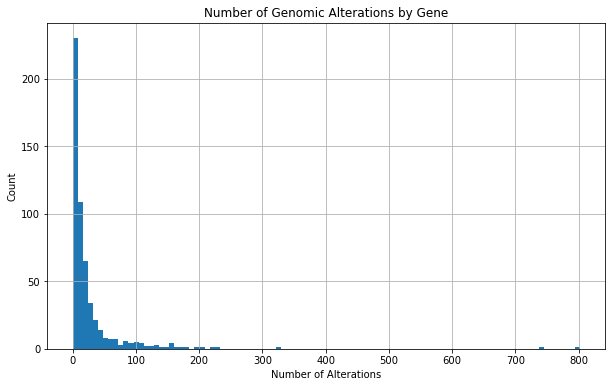

In [27]:
## visualize how many copy number alterations (loss or gain) for each gene

mutation_counts = df_genomic.iloc[:,:-1].abs().sum(axis=0).sort_values(ascending=False).to_frame('abs_cna')
mutation_counts.hist(bins=100, figsize=(10,6))
plt.title('Number of Genomic Alterations by Gene')
plt.ylabel('Count')
plt.xlabel('Number of Alterations');

##### Drop all genes with 0 alterations in all samples

In [28]:
to_drop = mutation_counts.query('abs_cna == 0').index
df_genomic = df_genomic.drop(columns=to_drop)
print('Number of remaining features: {}'.format(len(df_genomic.columns)))

Number of remaining features: 449


##### Checking for multicolinearity

In [29]:
corr_matrix = df_genomic.corr()
corr_pairs = pd.DataFrame([(corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.values[i,j])
                            for i in range(len(corr_matrix.columns)) 
                            for j in range(i+1,len(corr_matrix.columns)) 
                            if abs(corr_matrix.values[i,j]) > 0.8])

# Drop duplicate pairs
corr_pairs = corr_pairs[corr_pairs[0] < corr_pairs[1]]
corr_pairs = corr_pairs.drop_duplicates(subset=[0, 1])

print(corr_pairs)

               0               1         2
0           TAP1            TAP2  1.000000
1           TAP1         TMEM127  1.000000
3           MEN1         RPS6KA4  0.832240
4           TAP2         TMEM127  1.000000
10         CCND1            FGF4  0.813462
11         CCND1           FGF19  0.872641
14          IL7R          RICTOR  0.806917
15        CDKN1A            PIM1  0.818291
16         CSDE1            NRAS  0.906925
17          MST1           SETD2  1.000000
18          MST1            RHOA  1.000000
21         PPARG            RAF1  0.849139
23        MAP3K1            PLK2  0.804795
26          RXRA           TRAF2  1.000000
28        CTNNB1           MYD88  0.805322
29        CTNNB1            MLH1  0.805322
30          RYBP            SHQ1  0.896957
32         CSF3R             MPL  1.000000
33         CSF3R           MYCL1  0.829903
38        CDKN2A    CDKN2Ap14ARF  0.937897
39        CDKN2A  CDKN2Ap16INK4A  0.988912
45        DNAJB1          NOTCH3  0.825572
47         

In [30]:
# I will keep all the genes in the gene 1 column, and drop the correlated genes in gene 2 columns
to_drop = corr_pairs[1].values

df_genomic = df_genomic[[col for col in df_genomic.columns if col not in to_drop]]

print('Number of features remaining: {}'.format(len(df_genomic.columns)))

Number of features remaining: 416


##### Feature selection Using L1 regularization

In [31]:
## First find the best regularized logistic regression model using grid search
## I wil be using L1 regularization (LASSO), as it shrinks coefficients to 0

X, y = df_genomic.iloc[:,:-1], df_genomic['target']
X_scaled = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

lr = LogisticRegression(solver='liblinear', max_iter=400, penalty='l1', random_state=3)
params = [{
    'C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]  # the smaller the C, the stronger the penalty
}]

gs = GridSearchCV(estimator=lr, param_grid=params, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='roc_auc')
gs.fit(X_scaled, y)
gs.best_estimator_

LogisticRegression(C=1, max_iter=400, penalty='l1', random_state=3,
                   solver='liblinear')

In [32]:
lr_lasso = LogisticRegression(solver='liblinear', max_iter=400, penalty='l1', C=1, random_state=3)
lr_lasso.fit(X_scaled, y)

lasso_features_df = pd.DataFrame({
   'coefficients' : lr_lasso.coef_.ravel(),
   'features' : lr_lasso.feature_names_in_
})

lasso_features_df.head(10)

,coefficients,features
0,0.239968,TAP1
1,0.463515,ERRFI1
2,0.081970,STK19
3,0.000000,CRKL
4,-0.022052,STK11
5,0.000000,MEN1
6,-0.471264,B2M
7,0.145135,PMAIP1
8,0.000000,CDC73
9,0.094959,PIK3CA


Keep the features with non-zero coefficients determined by lasso regularization

In [33]:
X_scaled = X_scaled[lasso_features_df.query('coefficients != 0').features.values]
print('Number of remaining features: {}'.format(len(X_scaled.columns)))

Number of remaining features: 307


##### Filter remaining genes through Boruta algorithm

In [34]:
## First find best Random Forest model using 5-fold cross validation

rf = RandomForestClassifier(n_jobs=-1, random_state=3)
params = [{
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth' : list(range(5, 11, 1)),
    'n_estimators' : list(range(100, 501, 100))
}]

gs = GridSearchCV(estimator=rf, param_grid=params, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='roc_auc')
gs.fit(X_scaled, y)
gs.best_estimator_

RandomForestClassifier(max_depth=10, n_estimators=500, n_jobs=-1,
                       random_state=3)

In [35]:
rf = RandomForestClassifier(n_jobs=-1, max_depth=10, criterion='log_loss', n_estimators=500, random_state=3)
rf.fit(X_scaled, y)

boruta = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=10, alpha=0.01)
boruta.fit(X_scaled.values, y)

BorutaPy(alpha=0.01,
         estimator=RandomForestClassifier(criterion='log_loss', max_depth=10,
                                          n_estimators=61, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x239429C2E40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x239429C2E40)

In [36]:
boruta_df = pd.DataFrame({
    'column' : X_scaled.columns,
    'Rank' : boruta.ranking_,
    'Keep' : boruta.support_
})

boruta_df[boruta_df['Keep'] == True]

,column,Rank,Keep
16,CCND1,1,True
19,PTEN,1,True
90,RECQL4,1,True
96,CCNE1,1,True
118,TET1,1,True
130,MCL1,1,True
138,RB1,1,True
161,BRCA2,1,True
164,MDM2,1,True
190,TP53,1,True


PTEN, TP53, AR, BRCA2, and MYC are some commonly implicated genes in prostate cancer

In [37]:
top_genes = boruta_df[boruta_df['Keep'] == True]['column']

In [38]:
df_genomic_filt = df_genomic[top_genes]
print('Number of remaining features: {}'.format(len(df_genomic_filt.columns)))

Number of remaining features: 18


#### Clinical Data Feature Selection

Check for multicolinearity

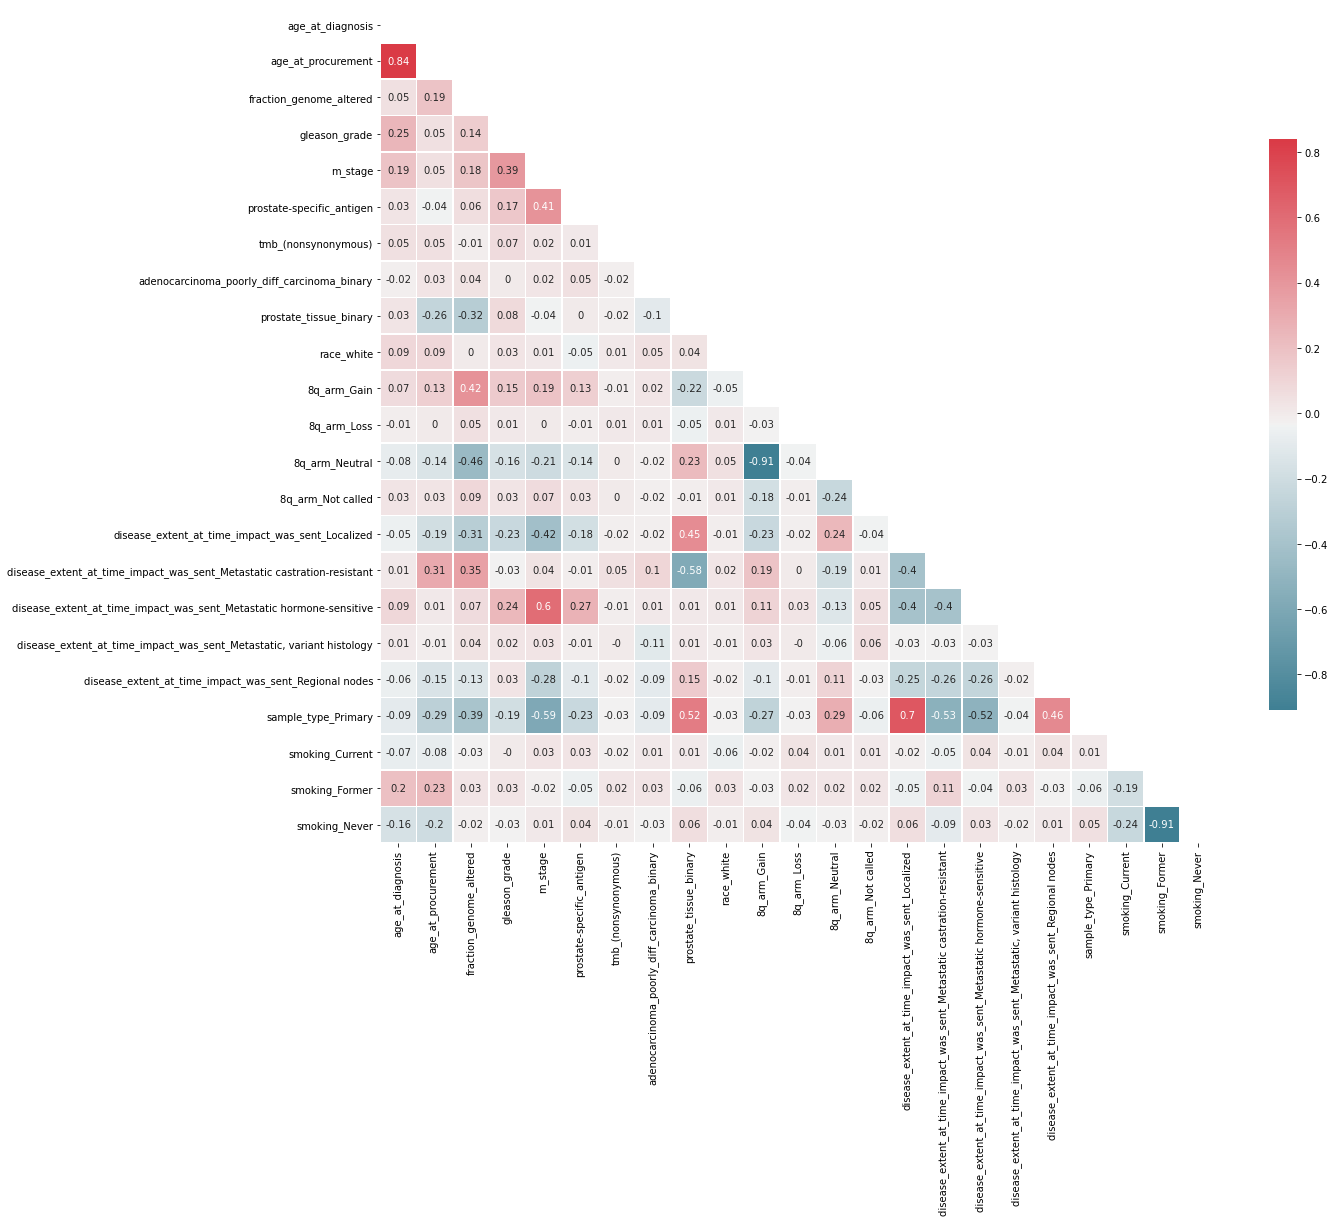

In [39]:
corr = df_clin.corr().round(2)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=0.5, cbar_kws={'shrink':0.5}, annot=True)
plt.tight_layout()

Age at diagnosis and age at procurement are correlated, which is expected. I will drop the age at procurement.

Additionally, some of the dummy variables that I created are correlated with each other, as expected (known as the dummy variable trap). To avoid this, I will have to drop one of the dummy variables from each category. Since the dummy variables were created by binary encoding each of the possible categories, the last category can be inferred with a 0 value in all the other categories. 
8q_arm_Neutral and 8q_arm_Gain are highly correlated, so I will drop 8q_arm_Neutral. The dummy variables smoking_Current and smoking_Former are also negatively correlated, so I will drop smoking_Never.

Furthermore, the sample type is correlated with the disease extent at a correlation coefficient of 0.7. This makes sense, as the sample type is either primary or metastatic, and there cannot be a metastatic sample if the disease was localized. I will remove the localized disease extent column.

In [40]:
to_drop = ['disease_extent_at_time_impact_was_sent_Localized', 'age_at_procurement', 'smoking_Never', '8q_arm_Neutral']
df_clin.drop(columns=to_drop, inplace=True)

Recheck correlations

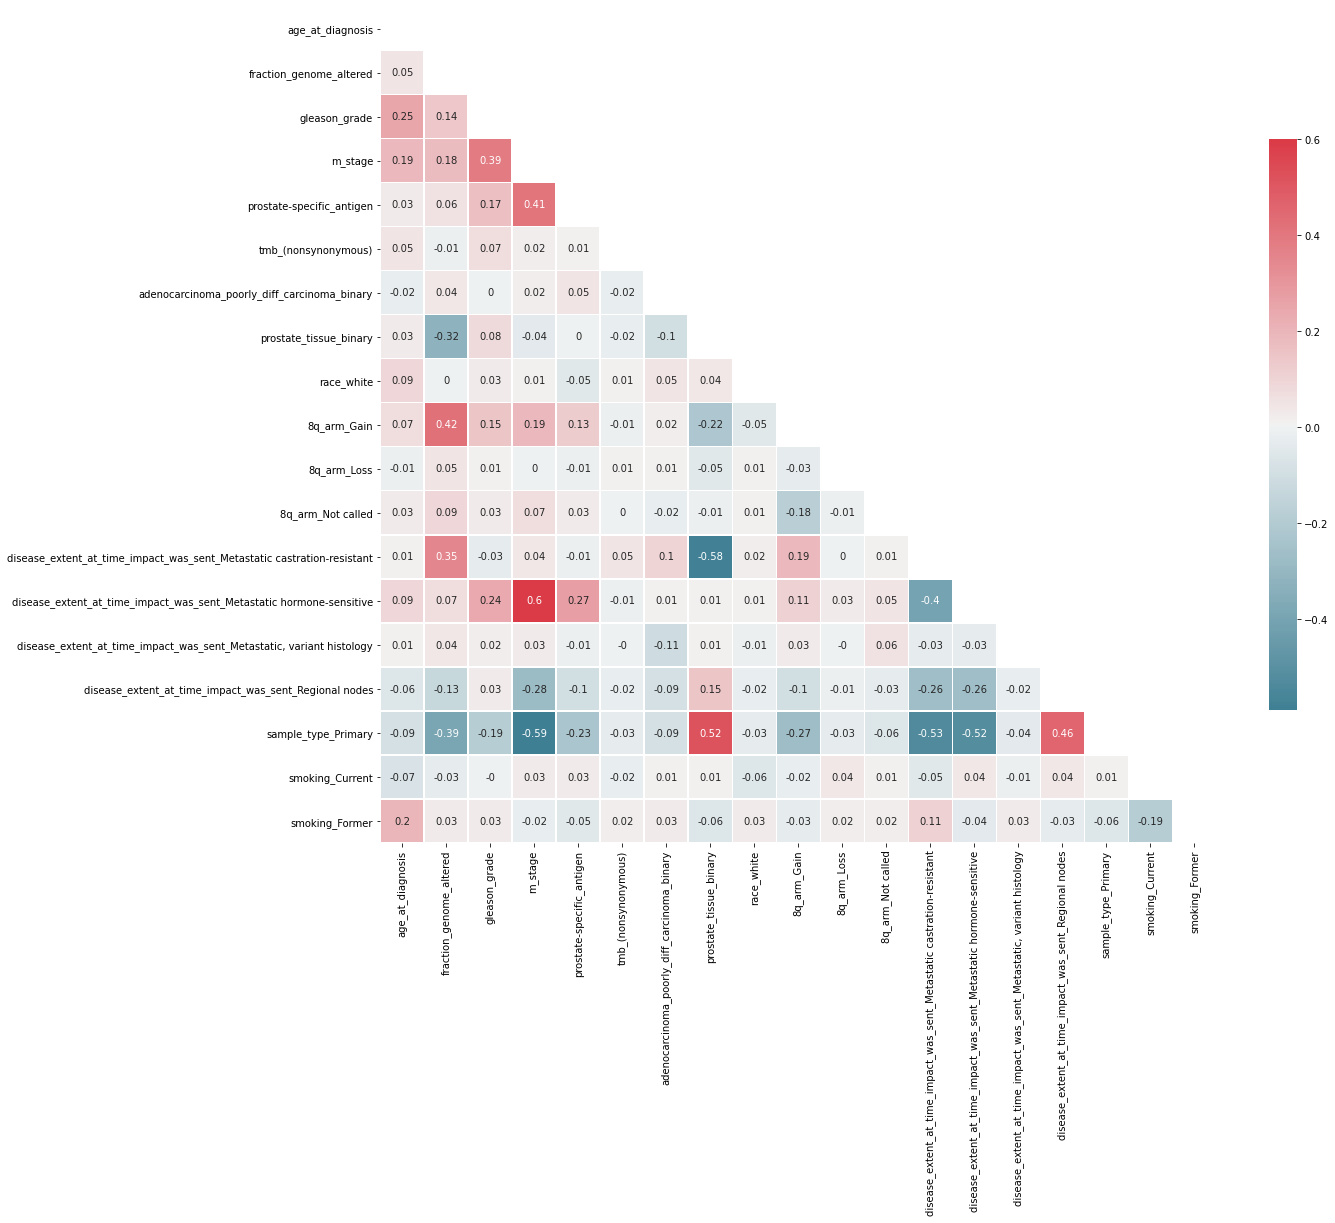

In [41]:
corr = df_clin.corr().round(2)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=0.5, cbar_kws={'shrink':0.5}, annot=True)
plt.tight_layout()

In [42]:
df_clin.shape

(2752, 19)

In [43]:
X, y = df_clin, df_genomic['target'].map({'Dead' : 0, 'Alive' : 1})

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

scaler = StandardScaler()
scaler.fit(X_train)
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

Training accuracy: 0.7766472868217055
Testing accuracy: 0.7601744186046512


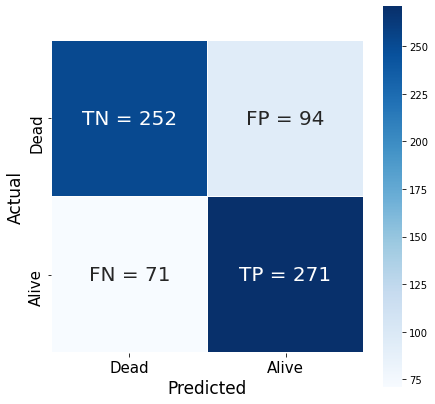

In [45]:
lr = LogisticRegression(penalty=None, random_state=3)
lr.fit(X_train, y_train)

print('Training accuracy: {}'.format(lr.score(X_train, y_train)))
print('Testing accuracy: {}'.format(lr.score(X_test, y_test)))

cm = confusion_matrix(y_test, lr.predict(X_test))

def plot_confusion_matrix(cm):

    # modify confusion matrix
    modified_cm = []
    for index,value in enumerate(cm):
        if index == 0:
            modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
        if index == 1:
            modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])

    # plot
    plt.figure(figsize=(7,7))
    sns.heatmap(cm, annot=np.array(modified_cm), cmap='Blues', fmt='', annot_kws={'size':20}, 
                linewidths=0.5, square=True, xticklabels=['Dead', 'Alive'], yticklabels=['Dead', 'Alive']);
    plt.ylabel('Actual', fontsize=17)
    plt.xlabel('Predicted', fontsize=17)
    plt.tick_params(labelsize=15)

plot_confusion_matrix(cm)

Looks like the baseline Logistic Regression model achieved 76% accuracy using all the features.

Lets see if including some regularization parameters can help select the most informative features.

Below, I test different regularization method and regularization strengths and extract the optimal parameters. The `C` parameter is the inverse strength of regularization, so decreasing `C` increases the regularization coefficient. I use elastic net regularization, which is a combination of L1 and L2 regularization. The l1 ratio parameter determines how much strong the L1 regularization is and is complementary to the strength of the L2 regularization. The values range between 0 and 1, with 0 being the same as only L2 regularization and 1 being the same as only L1 regularization.

##### Feature selection using elasticnet

In [46]:
X_scaled = StandardScaler().fit_transform(X)
params = {
    'C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    'l1_ratio' : [0, 0.2, 0.4, 0.6, 0.8, 1]
}
lr = LogisticRegression(solver='saga', penalty='elasticnet', max_iter=900, random_state=12)
gs = GridSearchCV(estimator=lr, param_grid=params, cv=KFold(n_splits=5, shuffle=True, random_state=42), n_jobs=-1, scoring='roc_auc')
gs.fit(X_scaled, y)

gs.best_estimator_

LogisticRegression(C=0.1, l1_ratio=0.6, max_iter=900, penalty='elasticnet',
                   random_state=12, solver='saga')

In [47]:
lr = LogisticRegression(C=0.1, l1_ratio=0.6, max_iter=900, penalty='elasticnet', solver='saga', random_state=3)
lr.fit(X_scaled, y)

LogisticRegression(C=0.1, l1_ratio=0.6, max_iter=900, penalty='elasticnet',
                   random_state=3, solver='saga')

In [48]:
enet_df = pd.DataFrame({
    'column' : X.columns,
    'coefficient' : np.abs(lr.coef_.ravel())
}).sort_values('coefficient', ascending=False)

enet_df

,column,coefficient
12,disease_extent_at_time_impact_was_sent_Metasta...,0.864968
16,sample_type_Primary,0.621489
1,fraction_genome_altered,0.571824
7,prostate_tissue_binary,0.501981
6,adenocarcinoma_poorly_diff_carcinoma_binary,0.344367
8,race_white,0.249705
2,gleason_grade,0.208185
18,smoking_Former,0.156965
4,prostate-specific_antigen,0.119296
14,disease_extent_at_time_impact_was_sent_Metasta...,0.103656


#### Feature selection using Boruta algorithm

In [49]:
## First find best Random Forest model using 5-fold cross validation

rf = RandomForestClassifier(n_jobs=-1, random_state=3)
params = [{
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth' : list(range(5, 11, 1)),
    'n_estimators' : list(range(100, 501, 100))
}]

gs = GridSearchCV(estimator=rf, param_grid=params, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='roc_auc')
gs.fit(X_scaled, y)
gs.best_estimator_

RandomForestClassifier(max_depth=10, n_estimators=400, n_jobs=-1,
                       random_state=3)

In [50]:
rf = RandomForestClassifier(n_jobs=-1, max_depth=10, n_estimators=400, random_state=3)
rf.fit(X_scaled, y)

boruta = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=12)
boruta.fit(X_scaled, y)

BorutaPy(estimator=RandomForestClassifier(max_depth=10, n_estimators=61,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x23944415940),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x23944415940)

In [51]:
boruta_df = pd.DataFrame({
    'column' : X.columns,
    'Rank' : boruta.ranking_,
    'Keep' : boruta.support_
})

In [52]:
clin_features_df = pd.merge(boruta_df, enet_df).sort_values('coefficient', ascending=False)
clin_features_df

,column,Rank,Keep,coefficient
12,disease_extent_at_time_impact_was_sent_Metasta...,1,True,0.864968
16,sample_type_Primary,1,True,0.621489
1,fraction_genome_altered,1,True,0.571824
7,prostate_tissue_binary,3,False,0.501981
6,adenocarcinoma_poorly_diff_carcinoma_binary,6,False,0.344367
8,race_white,9,False,0.249705
2,gleason_grade,1,True,0.208185
18,smoking_Former,8,False,0.156965
4,prostate-specific_antigen,1,True,0.119296
14,disease_extent_at_time_impact_was_sent_Metasta...,12,False,0.103656


Boruta and regularization gave varying results. Regularization ended up not shrinking any of the variables to 0 but 1. I will drop the features that were deemed to not keep by Bourta.

In [53]:
to_drop = clin_features_df.query('Keep == False')['column'].values
df_clin_filt = df_clin[[col for col in df_clin.columns if col not in to_drop]]

## Model Building <a class="anchor" id="sixth-bullet"></a>

In [54]:
df = pd.concat([df_clin_filt, df_genomic_filt, y], axis=1)
df.head()

,age_at_diagnosis,fraction_genome_altered,gleason_grade,prostate-specific_antigen,tmb_(nonsynonymous),disease_extent_at_time_impact_was_sent_Metastatic castration-resistant,sample_type_Primary,CCND1,PTEN,RECQL4,...,TP53,TCEB1,ANKRD11,AKT1,MYC,AMER1,FGF3,NBN,AR,target
0,42.6,0.5462,4.0,4.4,1.109155,1.0,0.0,0.0,-1.5,0.0,...,-1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,79.6,0.0604,4.0,211.0,3.327466,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,54.9,0.0023,5.0,5.8,1.109155,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,60.0,0.5102,5.0,3.0,6.654932,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,45.5,0.0134,3.0,27.4,1.109155,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [55]:
X, y = df.loc[:, df.columns != 'target'], df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=88, test_size=0.3) # 70-30 split

In [56]:
models = {
    'logistic_regression' : {
        'pipe' : Pipeline([('scaler', StandardScaler()), ('LR', LogisticRegression(penalty='elasticnet', random_state=42, solver='saga', max_iter=2000))]),
        'param_grid' : [{
            'LR__C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
            'LR__l1_ratio' : [0, 0.2, 0.4, 0.6, 0.8, 1]
        }]
    },
    'decision_tree' : {
        'pipe' : Pipeline([('scaler', StandardScaler()), ('DT', DecisionTreeClassifier(random_state=42))]),
        'param_grid' : [{
            'DT__criterion' : ['gini', 'entropy', 'log_loss'],
            'DT__max_depth' : list(range(5, 16, 2))
        }]
    },
    'random_forest' : {
        'pipe' : Pipeline([('scaler', StandardScaler()), ('RF', RandomForestClassifier(random_state=42))]),
        'param_grid' : [{
            'RF__criterion' : ['gini', 'entropy', 'log_loss'],
            'RF__max_depth' : list(range(5, 16, 2)),
            'RF__n_estimators' : list(range(100, 501, 100))
        }]
    },
    'knn' : {
        'pipe' : Pipeline([('scaler', StandardScaler()), ('KNN', KNeighborsClassifier())]),
        'param_grid' : [{
            'KNN__n_neighbors' : [5, 10, 15, 20],
            'KNN__weights' : ['uniform', 'distance']
        }]
    },
    'svm' : {
        'pipe' : Pipeline([('scaler', StandardScaler()), ('SVM', SVC(random_state=42))]),
        'param_grid' : [{
                'SVM__C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'SVM__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
                'SVM__degree' : [3, 4, 5, 6, 7, 8],
                'SVM__gamma' : ['scale', 'auto']
        }]
    },
    'xgb' : {
        'pipe' : Pipeline([('scaler', StandardScaler()), ('XGB', XGBClassifier(random_state=42))]),
        'param_grid' : [{
            'XGB__learning_rate' : [0.01, 0.05, 0.1, 0.2, 0.3],
            'XGB__max_depth' : list(range(5, 16, 2)),
            'XGB__n_estimators' : list(range(100, 501, 100))
        }]
    }
}

In [57]:
res = []
for mod, args in models.items():
    gs = GridSearchCV(estimator=args['pipe'], 
                      param_grid=args['param_grid'], 
                      scoring=['accuracy', 'roc_auc'], 
                      n_jobs=-1, 
                      cv=KFold(n_splits=10, shuffle=True, random_state=40), 
                      return_train_score=True, 
                      refit='roc_auc')
    gs.fit(X_train, y_train)
    res.append({'model' : mod, 'best_parameters' : gs.best_params_, 'score' : gs.best_score_})

In [58]:
pd.DataFrame(res)

,model,best_parameters,score
0,logistic_regression,"{'LR__C': 0.001, 'LR__l1_ratio': 0}",0.819021
1,decision_tree,"{'DT__criterion': 'entropy', 'DT__max_depth': 5}",0.824251
2,random_forest,"{'RF__criterion': 'entropy', 'RF__max_depth': ...",0.906831
3,knn,"{'KNN__n_neighbors': 5, 'KNN__weights': 'dista...",0.847111
4,svm,"{'SVM__C': 10, 'SVM__degree': 3, 'SVM__gamma':...",0.841943
5,xgb,"{'XGB__learning_rate': 0.1, 'XGB__max_depth': ...",0.923706


In [59]:
res

[{'model': 'logistic_regression',
  'best_parameters': {'LR__C': 0.001, 'LR__l1_ratio': 0},
  'score': 0.8190207677968658},
 {'model': 'decision_tree',
  'best_parameters': {'DT__criterion': 'entropy', 'DT__max_depth': 5},
  'score': 0.8242512199473317},
 {'model': 'random_forest',
  'best_parameters': {'RF__criterion': 'entropy',
   'RF__max_depth': 15,
   'RF__n_estimators': 500},
  'score': 0.9068311391533369},
 {'model': 'knn',
  'best_parameters': {'KNN__n_neighbors': 5, 'KNN__weights': 'distance'},
  'score': 0.8471109487620518},
 {'model': 'svm',
  'best_parameters': {'SVM__C': 10,
   'SVM__degree': 3,
   'SVM__gamma': 'scale',
   'SVM__kernel': 'rbf'},
  'score': 0.8419430350900058},
 {'model': 'xgb',
  'best_parameters': {'XGB__learning_rate': 0.1,
   'XGB__max_depth': 5,
   'XGB__n_estimators': 200},
  'score': 0.9237063864400394}]

It looks like XGBoost performed with the top score out of all the classifiers with AUC = 0.92. Random Forest also performed well with AUC = 0.90.

#### XGBoost Model

In [60]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

xgb = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=200, random_state=42)
xgb.fit(X_train, y_train)
print('Training accuracy: {}'.format(xgb.score(X_train, y_train)))
print('Testing accuracy: {}'.format(xgb.score(X_test, y_test)))

Training accuracy: 0.9719626168224299
Testing accuracy: 0.851089588377724


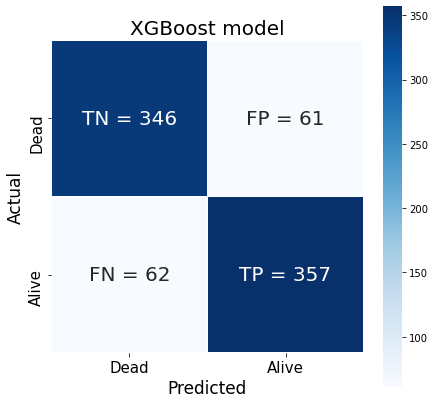

In [61]:
cm = confusion_matrix(y_test, xgb.predict(X_test))

plot_confusion_matrix(cm)
plt.title('XGBoost model', fontsize=20);

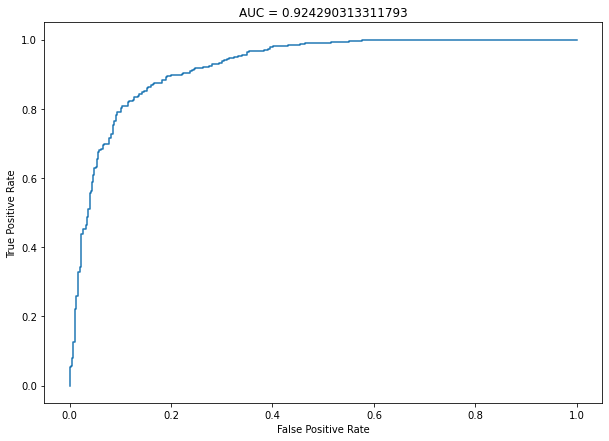

In [62]:
y_pred_proba = xgb.predict_proba(X_test)[::,-1]

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr, tpr)
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_title('AUC = ' + str(roc_auc_score(y_test, y_pred_proba)));

#### Random Forest Model

In [63]:
rf = RandomForestClassifier(max_depth=15, n_estimators=500, criterion='entropy', random_state=42)
rf.fit(X_train, y_train)
print('Training accuracy: {}'.format(rf.score(X_train, y_train)))
print('Testing accuracy: {}'.format(rf.score(X_test, y_test)))

Training accuracy: 0.9755970924195223
Testing accuracy: 0.8329297820823245


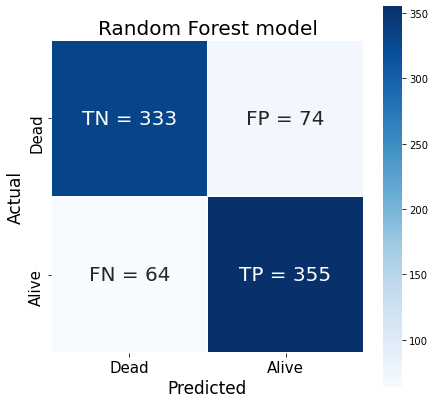

In [64]:
cm = confusion_matrix(y_test, rf.predict(X_test))
plot_confusion_matrix(cm)
plt.title('Random Forest model', fontsize=20);

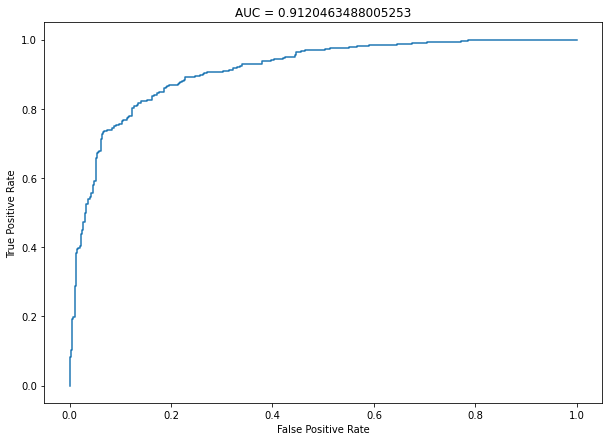

In [65]:
y_pred_proba = rf.predict_proba(X_test)[::,-1]

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr, tpr)
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_title('AUC = ' + str(roc_auc_score(y_test, y_pred_proba)));

## Hyperparameter Tuning <a class="anchor" id="seventh-bullet"></a>

The top performing models are both tree models, and judging from the high training accuracy (0.93 for XGBoost and 0.97 for Random Forest) they are overfitting. 


I will use 'roc_auc' for the scoring metric because optimizing this metric helps to control overfitting more than by optimizing for accuracy.

XGBoost has some penalty parameters that can be tuned to help with overfitting such as lambda and alpha.

#### XGBoost Hyperparameter Tuning

In [66]:
params = {
    'max_depth': [3, 5, 8], 
    'learning_rate' : [0.01, 0.03, 0.05], # smaller makes more robust to overfitting
    'colsample_bytree': [0.5, 0.8, 1.0], # fraction of features that are sampled to train each tree
    'reg_alpha': [0, 0.5, 1, 1.5],     # L1 regularization, default 0
    'reg_lambda': [1, 1.5, 2],    # L2 regularization, default 1
    'gamma': [0, 0.1, 0.5]  # minimum reduction in loss
}

gs = GridSearchCV(estimator=xgb, 
                  param_grid=params, 
                  scoring='roc_auc', 
                  n_jobs=-1, 
                  cv=KFold(n_splits=10, shuffle=True, random_state=40)
                  )
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=40, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     in...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.8, 1.0],
                         'gamma': [0, 0.1, 0.5],
                         'learning_rate': [0.01, 0.03, 0.05],
                         'max_depth': [3, 5, 8], 'reg_alpha': [0, 0.5, 1, 1.5],
                         'reg_lambda': [1, 1.5, 2]},
             scoring='roc_auc')

In [67]:
gs.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.5,
 'learning_rate': 0.05,
 'max_depth': 5,
 'reg_alpha': 0,
 'reg_lambda': 1.5}

In [68]:
gs.best_score_

0.9246999258518702

In [69]:
xgb_final = XGBClassifier(learning_rate=0.05, 
                          max_depth=5, 
                          n_estimators=200, 
                          random_state=66,
                          colsample_bytree=0.5,
                          gamma=0,
                          reg_alpha=0,
                          reg_lambda=1,
                          subsample=1)

xgb_final.fit(X_train, y_train)
print('Training accuracy: {}'.format(xgb_final.score(X_train, y_train)))
print('Testing accuracy: {}'.format(xgb_final.score(X_test, y_test)))

Training accuracy: 0.9247144340602285
Testing accuracy: 0.8389830508474576


It appears that the training accuracy went down a bit, so the model is slightly less overfit, and the testing accuracy did not decrease too much!

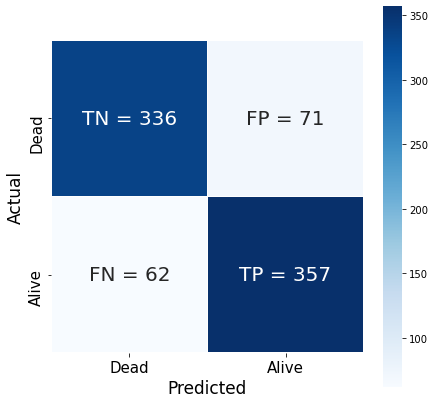

In [70]:
cm = confusion_matrix(y_test, xgb_final.predict(X_test))
plot_confusion_matrix(cm)

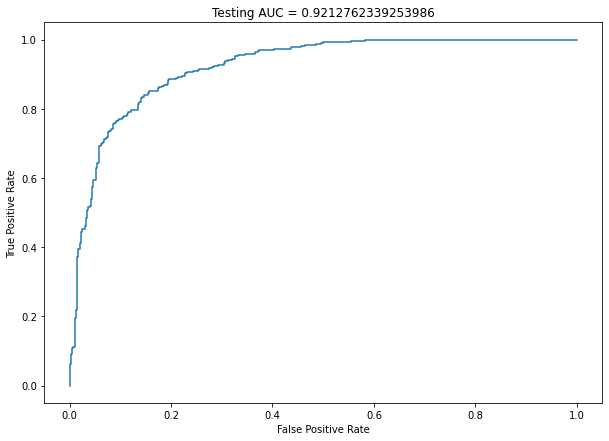

In [84]:
y_pred_proba = xgb_final.predict_proba(X_test)[::,-1]

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr, tpr)
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_title('Testing AUC = ' + str(roc_auc_score(y_test, y_pred_proba)));

#### Random Forest Hyperparameter Tuning

In [78]:
params = {
    'min_samples_split': [2, 4, 6, 8],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [1, 3, 5],
    'max_leaf_nodes' : [None, 2, 4, 6]
}

gs = GridSearchCV(
    estimator=rf, 
    param_grid=params, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=KFold(n_splits=10, shuffle=True, random_state=40)
)
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=40, shuffle=True),
             estimator=RandomForestClassifier(criterion='entropy', max_depth=15,
                                              n_estimators=500,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [None, 2, 4, 6],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 4, 6, 8]},
             scoring='roc_auc')

In [79]:
gs.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [80]:
print(gs.best_score_)

0.9070158396280217


In [81]:
rf_final = RandomForestClassifier(
    max_depth=15, max_features='sqrt', min_samples_leaf=1, min_samples_split=2,
    n_estimators=500, n_jobs=-1, random_state=29, criterion='entropy'
)

rf_final.fit(X_train, y_train)
print('Training accuracy: {}'.format(rf_final.score(X_train, y_train)))
print('Testing accuracy: {}'.format(rf_final.score(X_test, y_test)))

Training accuracy: 0.9724818276220145
Testing accuracy: 0.8305084745762712


It appears that even after hyperparameter tuning, the random forest model is still overfitting the training data. The XGBoost model may be the better choice for this problem if there is no additional data available.

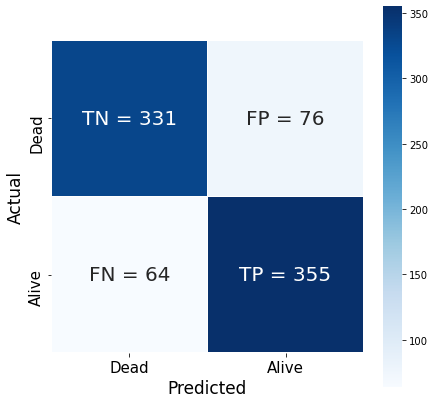

In [82]:
cm = confusion_matrix(y_test, rf_final.predict(X_test))
plot_confusion_matrix(cm)

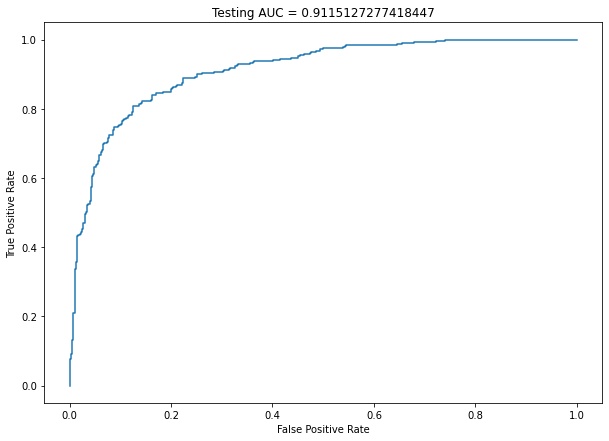

In [85]:
y_pred_proba = rf_final.predict_proba(X_test)[::,-1]

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr, tpr)
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_title('Testing AUC = ' + str(roc_auc_score(y_test, y_pred_proba)));

Overall, the XGBoost model performed the best in predicting the patients' outcomes, achieving an AUC score of 0.92 on the testing set.